In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from datetime import datetime, date
import json
from xgrads import open_CtlDataset
import geopandas as gpd
import requests
import hydrofunctions as hf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
# Choose a domain
domain = 'YUKO'

# calibration dates
# start calibration date    
st_dtcal = '2011-10-01'
# end calibration date
ed_dtcal = '2018-09-30'

# paths 
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
# data location
datapath = '/nfs/attic/dfh/2020_NPRB/data/'
# stream gauge data
flowpath = datapath+'stream_gage/'+domain+'/'
# calibration disgharge data
flowdatacal = flowpath+domain+'_discharge_cfs_'+st_dtcal+'_'+ed_dtcal+'.csv'
# calibration station gdf
flowstncal = flowpath+domain+'_gage_meta_'+st_dtcal+'_'+ed_dtcal+'.geojson'
# calibration station gdf projected
flowstnprojcal = flowpath+domain+'_gage_meta_proj_'+st_dtcal+'_'+ed_dtcal+'.geojson'
# calibration station gdf projected with indexes
flowstnprojcalidx = flowpath+domain+'_gage_meta_proj_idx_'+st_dtcal+'_'+ed_dtcal+'.geojson'
# station metadata
stnproj = gpd.read_file(flowstnprojcal)
# stn Q data
stnq=pd.read_csv(flowdatacal,index_col=0, parse_dates=True)

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

In [5]:
# HF calibration .ctl files
hf1path = SMpath+'hydroflowcal1/'
list_of_files1 = sorted( filter( os.path.isfile,
                        glob.glob(hf1path + '*.ctl') ) )
hf2path = SMpath+'hydroflowcal2/'
list_of_files2 = sorted( filter( os.path.isfile,
                        glob.glob(hf2path + '*.ctl') ) )
hf3path = SMpath+'hydroflowcal3/'
list_of_files3 = sorted( filter( os.path.isfile,
                        glob.glob(hf3path + '*.ctl') ) )
hf4path = SMpath+'hydroflowcal4/'
list_of_files4 = sorted( filter( os.path.isfile,
                        glob.glob(hf4path + '*.ctl') ) )
list_of_files = list_of_files1+list_of_files2+list_of_files3+list_of_files4
list_of_files

['/nfs/attic/dfh/2020_NPRB/domain_YUKO/snowmodel2023_cfsv2/hydroflowcal1/disc_s10_f1.ctl',
 '/nfs/attic/dfh/2020_NPRB/domain_YUKO/snowmodel2023_cfsv2/hydroflowcal1/disc_s20_f1.ctl',
 '/nfs/attic/dfh/2020_NPRB/domain_YUKO/snowmodel2023_cfsv2/hydroflowcal1/disc_s20_f2.5.ctl',
 '/nfs/attic/dfh/2020_NPRB/domain_YUKO/snowmodel2023_cfsv2/hydroflowcal1/disc_s30_f1.ctl',
 '/nfs/attic/dfh/2020_NPRB/domain_YUKO/snowmodel2023_cfsv2/hydroflowcal2/disc_s10_f2.ctl',
 '/nfs/attic/dfh/2020_NPRB/domain_YUKO/snowmodel2023_cfsv2/hydroflowcal2/disc_s20_f2.ctl',
 '/nfs/attic/dfh/2020_NPRB/domain_YUKO/snowmodel2023_cfsv2/hydroflowcal2/disc_s30_f2.ctl',
 '/nfs/attic/dfh/2020_NPRB/domain_YUKO/snowmodel2023_cfsv2/hydroflowcal3/disc_s10_f3.ctl',
 '/nfs/attic/dfh/2020_NPRB/domain_YUKO/snowmodel2023_cfsv2/hydroflowcal3/disc_s20_f3.ctl',
 '/nfs/attic/dfh/2020_NPRB/domain_YUKO/snowmodel2023_cfsv2/hydroflowcal3/disc_s30_f3.ctl',
 '/nfs/attic/dfh/2020_NPRB/domain_YUKO/snowmodel2023_cfsv2/hydroflowcal4/disc_s10_f4.ctl

In [6]:
# baseline hf run 
rbpath = SMpath+'outputs/wo_assim/disc_base.ctl'
q = open_CtlDataset(rbpath)
q

,Array,Chunk
Bytes,4.33 GiB,1.73 MiB
Shape,"(2557, 1, 527, 863)","(1, 1, 527, 863)"
Count,2557 Tasks,2557 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.33 GiB,1.73 MiB
Shape,"(2557, 1, 527, 863)","(1, 1, 527, 863)"
Count,2557 Tasks,2557 Chunks
Type,float32,numpy.ndarray


In [7]:
def kge(simulations, evaluation):
    """Original Kling-Gupta Efficiency (KGE) and its three components
    (r, α, β) as per `Gupta et al., 2009
    <https://doi.org/10.1016/j.jhydrol.2009.08.003>`_.

    Note, all four values KGE, r, α, β are returned, in this order.

    :Calculation Details:
        .. math::
           E_{\\text{KGE}} = 1 - \\sqrt{[r - 1]^2 + [\\alpha - 1]^2
           + [\\beta - 1]^2}
        .. math::
           r = \\frac{\\text{cov}(e, s)}{\\sigma({e}) \\cdot \\sigma(s)}
        .. math::
           \\alpha = \\frac{\\sigma(s)}{\\sigma(e)}
        .. math::
           \\beta = \\frac{\\mu(s)}{\\mu(e)}

        where *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, *cov* is the covariance, *σ* is the
        standard deviation, and *μ* is the arithmetic mean.

    """
    # calculate error in timing and dynamics r
    # (Pearson's correlation coefficient)
    sim_mean = np.mean(simulations, axis=0, dtype=np.float64)
    obs_mean = np.mean(evaluation, dtype=np.float64)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0, dtype=np.float64)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0, dtype=np.float64)
                    * np.sum((evaluation - obs_mean) ** 2,
                             dtype=np.float64))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation, dtype=np.float64)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0, dtype=np.float64)
            / np.sum(evaluation, dtype=np.float64))
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return kge_, r, alpha, beta

# see what data is available for the time period of interest

<Axes: xlabel='datetimeUTC'>

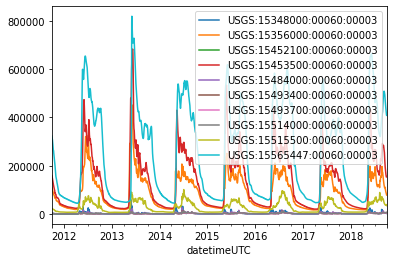

In [8]:
stnq.plot()

In [9]:
stn_list = ['15565447','15453500','15356000']
instn = stnproj[stnproj.site_no.isin(stn_list)].reset_index(drop=True)
instn['xidx'] = instn.xidx.astype(int)
instn['yidx'] = instn.yidx.astype(int)
instn

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,xidx,yidx,geometry
0,USGS,15356000,YUKON R AT EAGLE AK,ST,644722.0,1411152.0,64.789168,-141.200089,M,T,...,None,None,None,None,None,None,None,533,289,POINT (604614.263 1705991.348)
1,USGS,15453500,YUKON R NR STEVENS VILLAGE AK,ST,655232.0,1494304.0,65.875101,-149.720349,M,T,...,None,None,None,None,None,None,None,369,316,POINT (195477.028 1774845.188)
2,USGS,15565447,YUKON R AT PILOT STATION AK,ST,615604.0,1625250.0,61.933687,-162.882936,M,S,...,None,None,None,None,None,None,None,106,149,POINT (-463483.512 1359601.750)


533 289 15356000


-0.5341601310973787

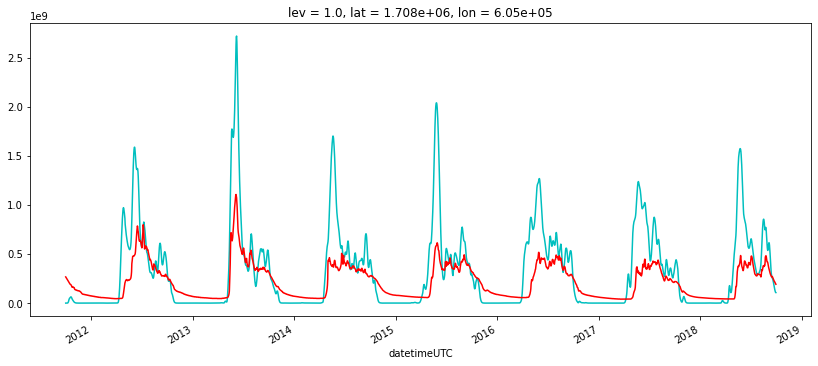

In [17]:
i = 0
xidx = instn.xidx[i]
yidx = instn.yidx[i]
stn = instn.site_no[i]
print(xidx,yidx,stn)
fig, ax = plt.subplots(figsize=(14,6))
mod_q_total = q.fast.isel(lon=xidx,lat=yidx) + q.slow.isel(lon=xidx,lat=yidx)
mod_q_total.plot(color='c',ax=ax)
stn_q = stnq['USGS:'+stn+':00060:00003']*60*60*24/35.3147
stn_q.plot(color='r',ax=ax)
kge_, r, alpha, beta = kge(np.squeeze(mod_q_total.values),stn_q.values)
kge_

369 316 15453500


-0.4546840002222605

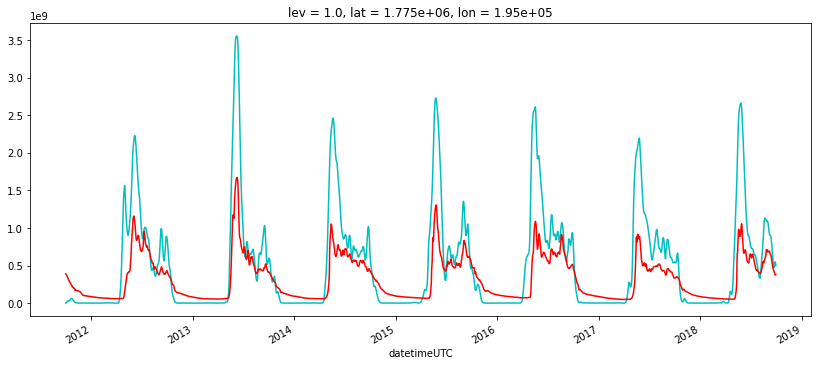

In [12]:
i = 1
xidx = instn.xidx[i]
yidx = instn.yidx[i]
stn = instn.site_no[i]
print(xidx,yidx,stn)
fig, ax = plt.subplots(figsize=(14,6))
mod_q_total = q.fast.isel(lon=xidx,lat=yidx) + q.slow.isel(lon=xidx,lat=yidx)
mod_q_total.plot(color='c',ax=ax)
stn_q = stnq['USGS:'+stn+':00060:00003']*60*60*24/35.3147
stn_q.plot(color='r',ax=ax)
kge_, r, alpha, beta = kge(np.squeeze(mod_q_total.values),stn_q.values)
kge_

106 149 15565447


-0.4604008608649459

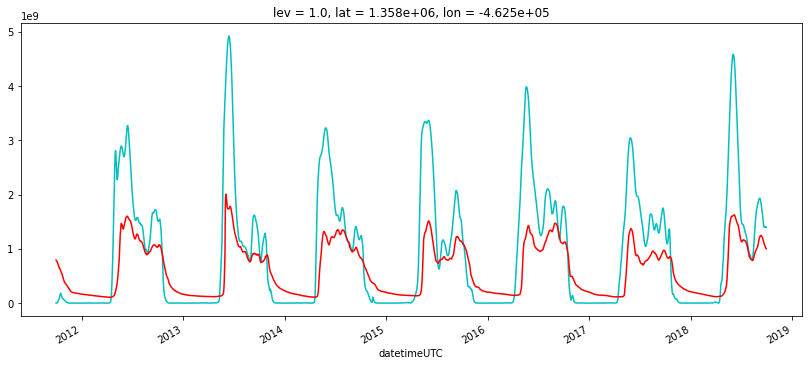

In [13]:
i = 2
xidx = instn.xidx[i]
yidx = instn.yidx[i]
stn = instn.site_no[i]
print(xidx,yidx,stn)
fig, ax = plt.subplots(figsize=(14,6))
mod_q_total = q.fast.isel(lon=xidx,lat=yidx) + q.slow.isel(lon=xidx,lat=yidx)
mod_q_total.plot(color='c',ax=ax)
stn_q = stnq['USGS:'+stn+':00060:00003']*60*60*24/35.3147
stn_q.plot(color='r',ax=ax)
kge_, r, alpha, beta = kge(np.squeeze(mod_q_total.values),stn_q.values)
kge_

In [14]:
# function to calculate r^2 without nan values
def get_r2(modq,stnq):
    #remove days where station has nan values 
    idx = np.where(~np.isnan(stnq))
    modq = modq[idx]
    stnq = stnq[idx]

    #R-squared value
    r2 = r2_score(stnq, modq)

    return r2

In [36]:
# function to calculate NSE without nan values
def get_nse(modq,stnq):
    #remove days where station has nan values 
    idx = np.where(~np.isnan(stnq))
    modq = modq[idx]
    stnq = stnq[idx]

    # Nash-Sutcliffe model efficiency coefficient, 1 = perfect, assumes normal data 
    nse_top = sum((stnq - modq)**2)
    nse_bot = sum((stnq - np.mean(stnq))**2)
    nse = (1-(nse_top/nse_bot))
    return nse

15356000 y= 289 x= 533
15453500 y= 316 x= 369
15565447 y= 149 x= 106


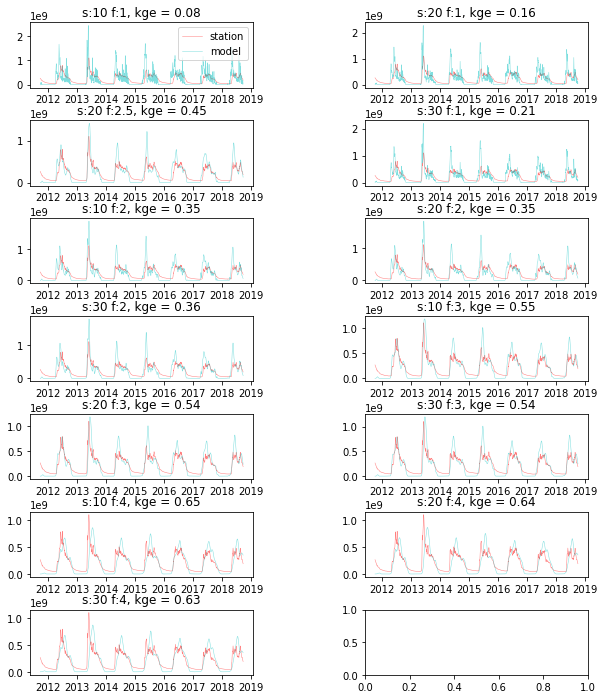

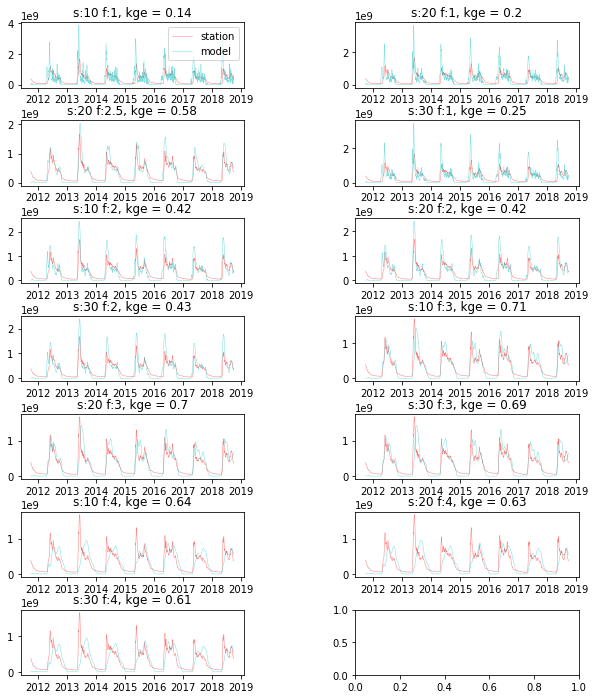

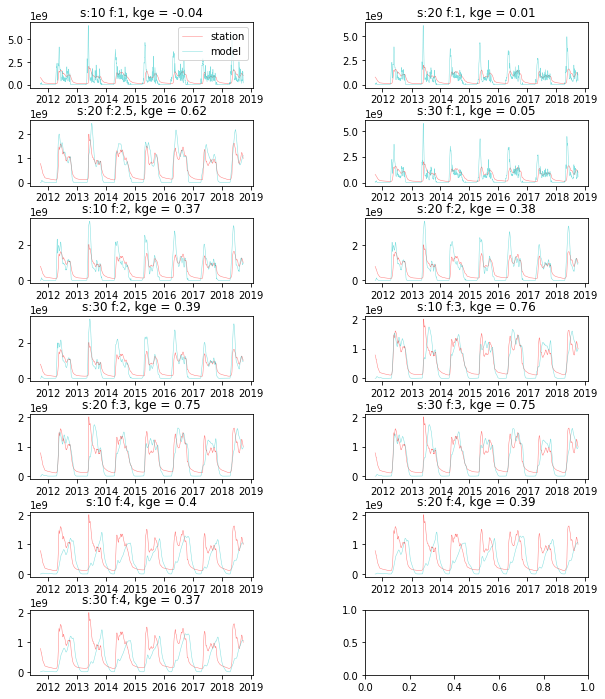

In [16]:

for i in range(len(instn)):
    yidx = instn.yidx[i]
    xidx = instn.xidx[i]
    stn = instn.site_no[i]
    print(stn,'y=',yidx,'x=',xidx)
    
    fig, axs = plt.subplots(nrows=7, figsize=(10, 12), ncols=2, facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.5)
    axs = axs.ravel()
    for n in range(len(list_of_files)):
            ctlFile = list_of_files[n]
            q = open_CtlDataset(ctlFile)
            #q=q.assign_coords({"lat": np.flipud(topo.y.values)-int(domains[domain]['cellsize']),"lon": topo.x.values-int(domains[domain]['cellsize'])})
            # convert units from cfs to cmd
            stn_q = stnq['USGS:'+stn+':00060:00003']*60*60*24/35.3147
            #print('stn = ',np.trapz(mod_q_total.values))
#             # fill missing values
#             stn_q_fill = stn_q.interpolate(method='polynomial', order=2)
            stn_q_fill=stn_q
            # model discharge
            mod_q_total = q.fast.isel(lon=xidx,lat=yidx,lev=0) + q.slow.isel(lon=xidx,lat=yidx,lev=0)  
            #print(np.trapz(mod_q_total.values))
            # calc R^2
            #remove days where station has nan values 
            idx = np.where(~np.isnan(stn_q.values))
            modqs = mod_q_total.values[idx]
            stnqs = stn_q.values[idx]
            kge_, r, alpha, beta = kge(modqs,stnqs)
            # plot
            axs[n].plot(stn_q_fill.index,stn_q_fill, color = 'r',label = 'station',linewidth=.5,alpha=0.5)
            axs[n].plot(stn_q_fill.index,mod_q_total, color = 'c',label = 'model',linewidth=.5,alpha=0.5)
            
            if n ==2:
                axs[n].set_title('s:'+ctlFile[77:79]+' f:'+ctlFile[-7:-4]+', kge = '+str(round(kge_,2)))
            else:
                axs[n].set_title('s:'+ctlFile[77:79]+' f:'+ctlFile[-5:-4]+', kge = '+str(round(kge_,2)))

            if n == 0:
                axs[n].legend()
    fig.savefig('HFcal_USGS_'+stn+'.png',dpi=300)
        

In [127]:
# #evalueate R^2 scores for each of the hydroflow experiments at each station 
# r2 = np.empty([len(instn),5])
# int_dif = np.empty([len(instn),5])

# for n in range(1,6):
#     ctlFile = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/model_runs/hydroflow'+str(n)+'/disc_2009-2011.ctl'
#     q = open_CtlDataset(ctlFile)
#     q=q.assign_coords({"lat": np.flipud(topo.y.values)-int(domains[domain]['cellsize']),"lon": topo.x.values-int(domains[domain]['cellsize'])})
    
#     for i in range(len(instn)):
#         xidx = instn.xidx[i]
#         yidx = instn.yidx[i]
#         stn = instn.site_no[i]
#         # station discharge
#         # convert units from cms to cmd
#         stn_q = stnq['USGS:'+stn+':00060:00003']*60*60*24/35.3147
#         # fill missing values
#         stn_q_fill = stn_q.interpolate(method='polynomial', order=2)
#         # model discharge
#         mod_q_total = q.fast.isel(lon=xidx,lat=yidx) + q.slow.isel(lon=xidx,lat=yidx)
#         mod_q_slow = q.slow.isel(lon=xidx,lat=yidx)
#         mod_q_fast = q.fast.isel(lon=xidx,lat=yidx)
# #         #calc area under the curve 
# #         aucmod = np.trapz(mod_q_total)
# #         aucobs = np.trapz(stn_q_fill)
# #         intdif = aucmod-aucobs
# #         int_dif[i,n-1] = intdif
#         # calc R^2
#         score = r2_score(stn_q_fill, mod_q_total)
#         print(n,xidx,yidx,stn,score)
#         r2[i,n-1] = score

1 405 280 15803000 -3.0844208655080187
1 609 152 15875000 0.031872715150229824
1 726 260 15896000 -0.5093853731703071
1 743 122 15908000 0.38169735936332183
1 829 226 15955000 0.16988120262725082
1 861 228 15960000 -0.6740977897649325
2 405 280 15803000 -2.64957140251756
2 609 152 15875000 0.6056479170096216
2 726 260 15896000 -0.20319103939249916
2 743 122 15908000 0.5185190796754191
2 829 226 15955000 0.48779928751036217
2 861 228 15960000 -0.6140300034370825
3 405 280 15803000 -0.6563112060277034
3 609 152 15875000 0.25178974519938746
3 726 260 15896000 0.6342847490020673
3 743 122 15908000 0.5272590852466212
3 829 226 15955000 0.5459283362490586
3 861 228 15960000 -0.39952519189325364
4 405 280 15803000 -0.6906463408750088
4 609 152 15875000 0.08355659145073768
4 726 260 15896000 0.34177710298987063
4 743 122 15908000 0.42328336762533625
4 829 226 15955000 0.3545950499426159
4 861 228 15960000 -0.07243445388366476
5 405 280 15803000 -0.6919479499301227
5 609 152 15875000 0.00078000

In [104]:
plt.imshow(int_dif, cmap='hot')
plt.colorbar()
r2.mean(axis=0)

array([-0.61407546, -0.30913769,  0.15057092,  0.07335522,  0.02157207])

array([-0.61407546, -0.30913769,  0.15057092,  0.07335522,  0.02157207])

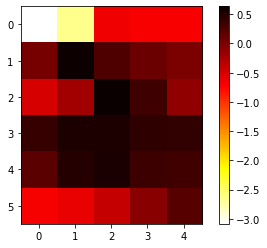

In [128]:
plt.imshow(r2, cmap='hot_r')
plt.colorbar()
r2.mean(axis=0)